# Instrument Detector

## By Galo Pérez Gallego

Creation of a model using cnn that predict the instrument in an image. There are 30 classes (30 different instruments): 'acordian', 'alphorn', 'bagpipes', 'banjo', 'bongo drum', 'casaba', 'castanets', 'clarinet', 'clavichord', 'concertina', 'Didgeridoo', 'drums', 'dulcimer', 'flute', 'guiro', 'guitar', 'harmonica', 'harp', 'marakas', 'ocarina', 'piano', 'saxaphone', 'sitar', 'steel drum', 'Tambourine', 'trombone', 'trumpet', 'tuba', 'violin', 'Xylophone'.

## Downloading and Exploring the Data

I decided to use a instrument dataset from kaggle that I downloaded with the opendatasets library.

In [3]:
!py -m pip install opendatasets --upgrade --quiet

In [4]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/datasets/gpiosenka/musical-instruments-image-classification'
od.download(dataset_url)

Skipping, found downloaded files in ".\musical-instruments-image-classification" (use force=True to force download)


In [5]:
import os

data_dir = './musical-instruments-image-classification'

classes = os.listdir(data_dir + "/train")
print(classes)

['acordian', 'alphorn', 'bagpipes', 'banjo', 'bongo drum', 'casaba', 'castanets', 'clarinet', 'clavichord', 'concertina', 'Didgeridoo', 'drums', 'dulcimer', 'flute', 'guiro', 'guitar', 'harmonica', 'harp', 'marakas', 'ocarina', 'piano', 'saxaphone', 'sitar', 'steel drum', 'Tambourine', 'trombone', 'trumpet', 'tuba', 'violin', 'Xylophone']


In [6]:
banjo_files = os.listdir(data_dir + "/train/banjo")
print('No. of training examples for banjo:', len(banjo_files))
print(banjo_files[:5])

No. of training examples for banjo: 155
['001.jpg', '002.jpg', '003.jpg', '004.jpg', '005.jpg']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

dataset = ImageFolder(data_dir +'/train', transform=ToTensor())

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 224, 224]) 0


tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [9]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [10]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    plt.imshow(img_tensor.permute(1,2,0))

Label: Didgeridoo (0)


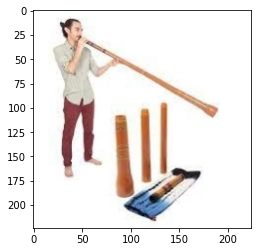

In [11]:
show_image(*dataset[0])

In [12]:
train_ds = dataset
valid_ds = ImageFolder(data_dir +'/valid', transform=ToTensor())

In [13]:
from torch.utils.data.dataloader import DataLoader

batch_size=16

In [14]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size*2, num_workers=4, pin_memory=True)

In [15]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(16, 16))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1, 2, 0))
        break

## Visualizing the data

We now preview a batch (16 images) of the dataset, accompanied by all the labels.

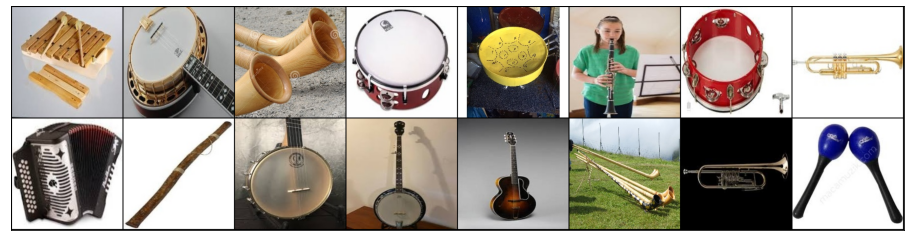

In [16]:
show_batch(train_dl)

In [17]:
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}],{} train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, "last_lr: {:.5f},".format(result['lrs'][-1]) if 'lrs' in result else '', 
            result['train_loss'], result['val_loss'], result['val_acc']))
    
    def forward(self, xb):
        return self.network(xb)

## Building the model

We build the neural network model, in this case we use the pre-trained model ResNet50. We add Dropout to avoid overfitting and we add a 30 output final layer.

In [18]:
from torchvision import models
from torchvision.models import ResNet50_Weights


class InstrumentsModel(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        self.network.fc = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(self.network.fc.in_features, num_classes))
       


In [19]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

## Training the model
We are going to use some techniques for a better result:

**Learning rate scheduling**: Instead of using a fixed learning rate, we will use a learning rate scheduler, which will change the learning rate after every batch of training. There are many strategies for varying the learning rate during training, and the one we'll use is called the "One Cycle Learning Rate Policy", which involves starting with a low learning rate, gradually increasing it batch-by-batch to a high learning rate for about 30% of epochs, then gradually decreasing it to a very low value for the remaining epochs.

**Weight decay**: We also use weight decay, which is yet another regularization technique which prevents the weights from becoming too large by adding an additional term to the loss function.

**Gradient clipping**: Apart from the layer weights and outputs, it also helpful to limit the values of gradients to a small range to prevent undesirable changes in parameters due to large gradient values.

In [20]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
device = get_default_device()
device

device(type='cuda')

In [22]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [23]:
model = InstrumentsModel(len(dataset.classes))
to_device(model, device);

In [24]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 3.413248062133789, 'val_acc': 0.10170455276966095}]

In [25]:
epochs = 15
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [26]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, valid_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [0],last_lr: 0.00152, train_loss: 1.2169, val_loss: 1.7677, val_acc: 0.5875


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [1],last_lr: 0.00436, train_loss: 1.6648, val_loss: 1.7225, val_acc: 0.6136


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [2],last_lr: 0.00760, train_loss: 1.8732, val_loss: 33.4994, val_acc: 0.1267


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [3],last_lr: 0.00971, train_loss: 1.8951, val_loss: 2.1513, val_acc: 0.3778


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [4],last_lr: 0.00994, train_loss: 1.6865, val_loss: 1.8031, val_acc: 0.4477


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [5],last_lr: 0.00950, train_loss: 1.5241, val_loss: 1.2953, val_acc: 0.6011


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [6],last_lr: 0.00867, train_loss: 1.4141, val_loss: 4.1611, val_acc: 0.2170


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [7],last_lr: 0.00750, train_loss: 1.2736, val_loss: 0.8027, val_acc: 0.7364


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [8],last_lr: 0.00611, train_loss: 1.0878, val_loss: 0.8855, val_acc: 0.7420


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [9],last_lr: 0.00463, train_loss: 0.9465, val_loss: 0.5895, val_acc: 0.8318


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [10],last_lr: 0.00317, train_loss: 0.6967, val_loss: 0.5022, val_acc: 0.9006


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [11],last_lr: 0.00188, train_loss: 0.4852, val_loss: 0.2794, val_acc: 0.9159


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [12],last_lr: 0.00087, train_loss: 0.2739, val_loss: 0.1729, val_acc: 0.9284


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [13],last_lr: 0.00022, train_loss: 0.1334, val_loss: 0.2115, val_acc: 0.9381


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch [14],last_lr: 0.00000, train_loss: 0.1024, val_loss: 0.1968, val_acc: 0.9381
CPU times: total: 5min 39s
Wall time: 25min 47s


In [27]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

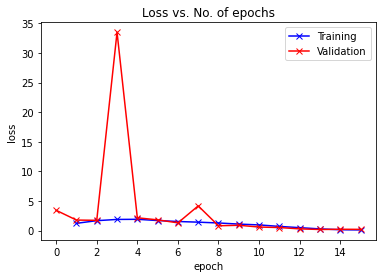

In [28]:
plot_losses(history)

In [29]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

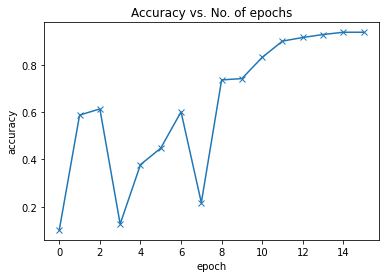

In [30]:
plot_accuracies(history)

# Lets make some predictions

Before making any prediction, I create the predict_image function, which presents the result in a more legible way.

In [31]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [32]:
test_dl = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
evaluate(model, test_dl)

{'val_loss': 0.08832758665084839, 'val_acc': 0.96875}

In [33]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

Label: Didgeridoo , Predicted: Didgeridoo


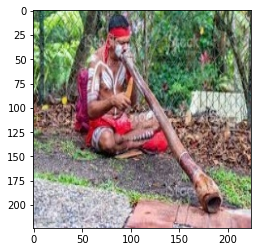

In [34]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: clarinet , Predicted: clarinet


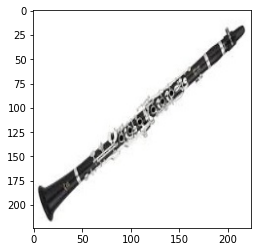

In [35]:
img, label = test_dataset[50]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

In [36]:
from PIL import Image
import torchvision.transforms as transforms

img_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = (0,0,0), std = (1,1,1))
])

def predict_from_dir(img_dir, label, model):
  img = Image.open(img_dir)
  label = label
  img = img_transform(img)

  plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
  print('Label:', label, ', Predicted:', predict_image(img, model))
  

Label: piano , Predicted: piano


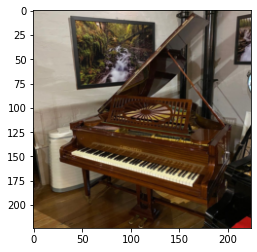

In [37]:
predict_from_dir("piano.jpg","piano",model)

Label: violin , Predicted: violin


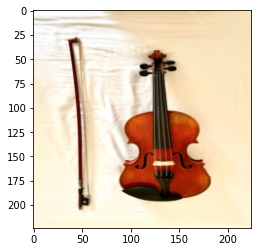

In [38]:
predict_from_dir("violin.jpg","violin",model)

Label: flute , Predicted: flute


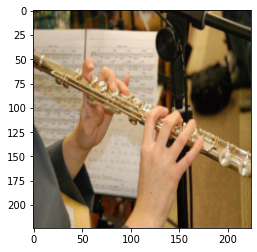

In [42]:
predict_from_dir("flute.jpg","flute",model)